# Neural Spline Flow

In [1]:
# Import required packages
import torch
import numpy as np
import normflow as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Set up model

# Define flows
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

# Initialize ActNorm
x_np, _ = make_moons(2 ** 9, noise=0.1)
x = torch.tensor(x_np).float().to(device)
_ = nfm.log_prob(x)

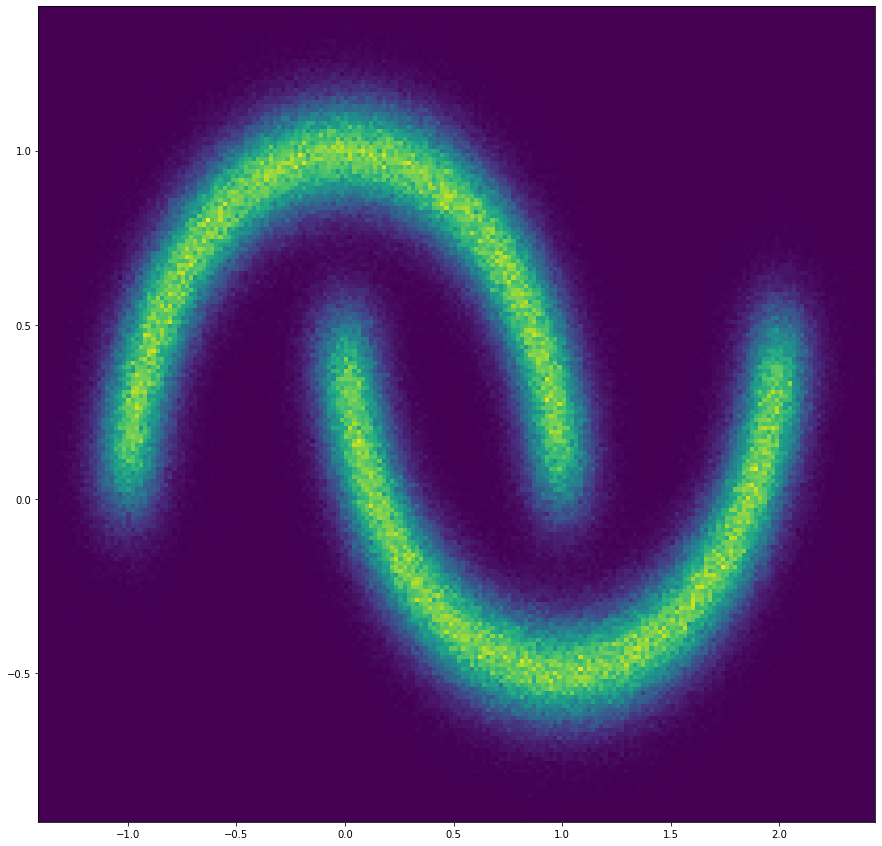

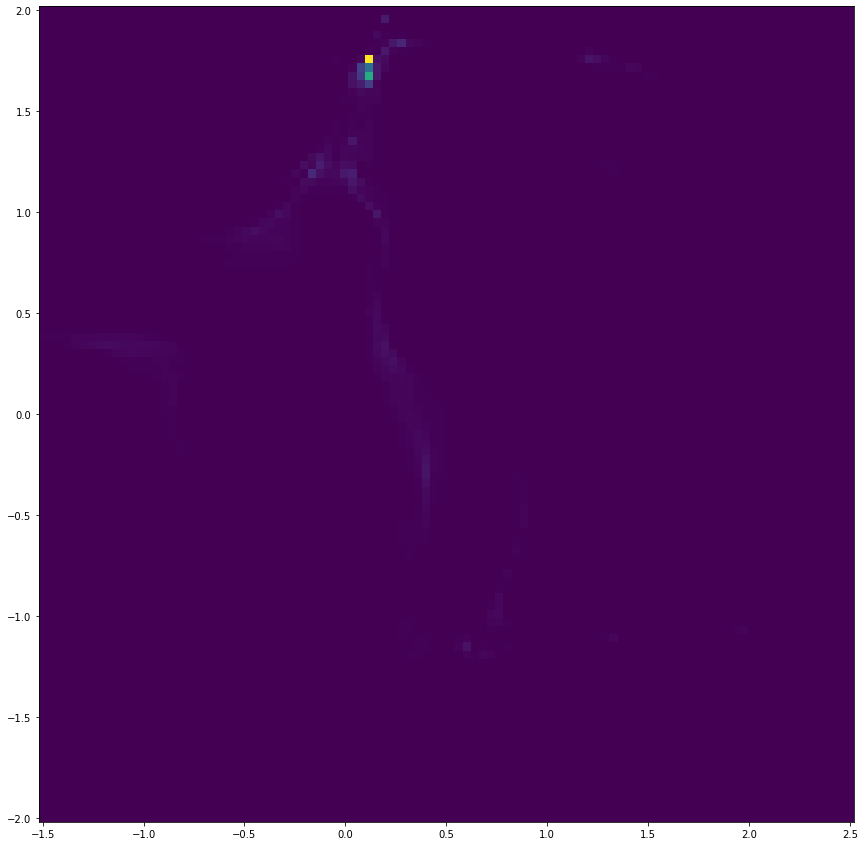

In [3]:
# Plot prior distribution
x_np, _ = make_moons(2 ** 20, noise=0.1)
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
plt.show()

# Plot initial posterior distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

  5%|██▌                                                | 499/10000 [01:31<32:51,  4.82it/s]

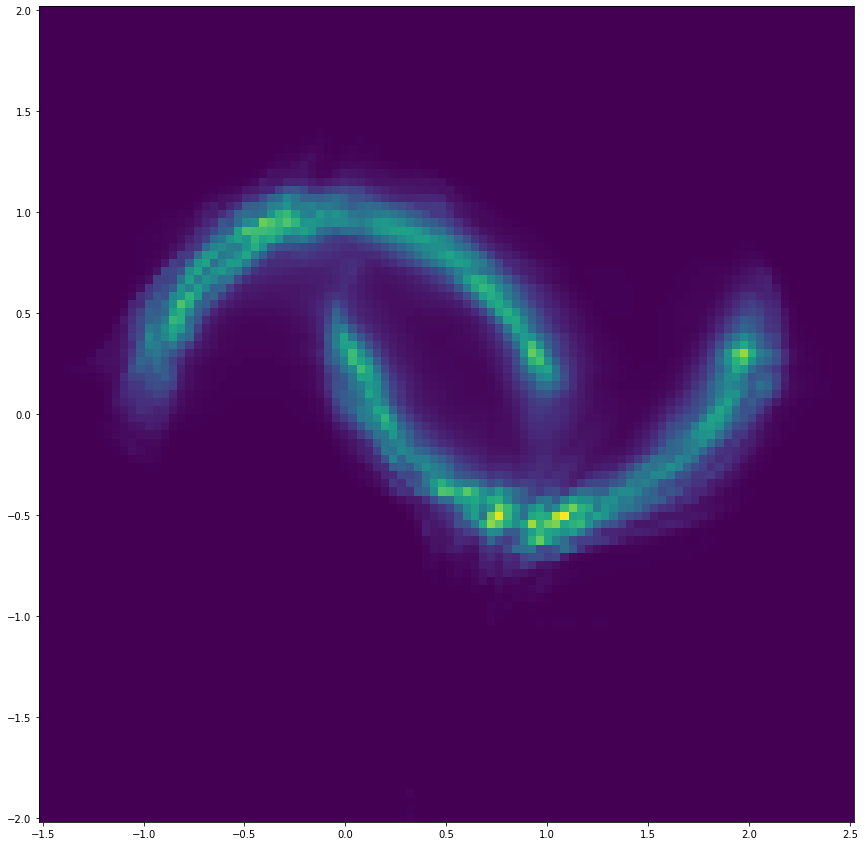

 10%|█████                                              | 999/10000 [03:06<26:38,  5.63it/s]

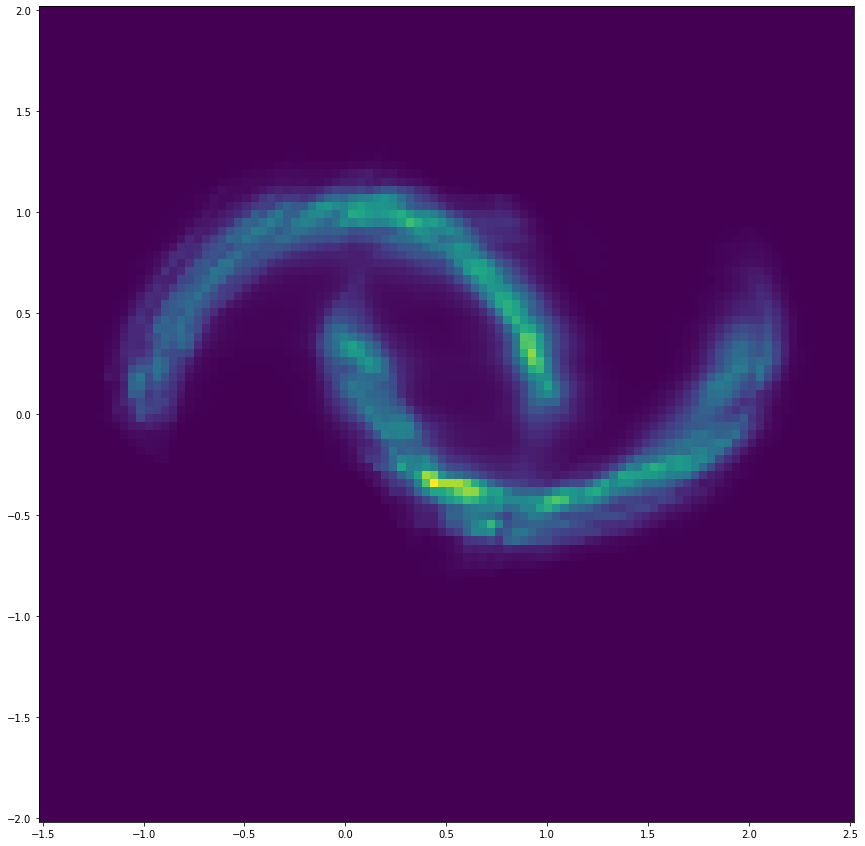

 15%|███████▍                                          | 1499/10000 [04:38<26:11,  5.41it/s]

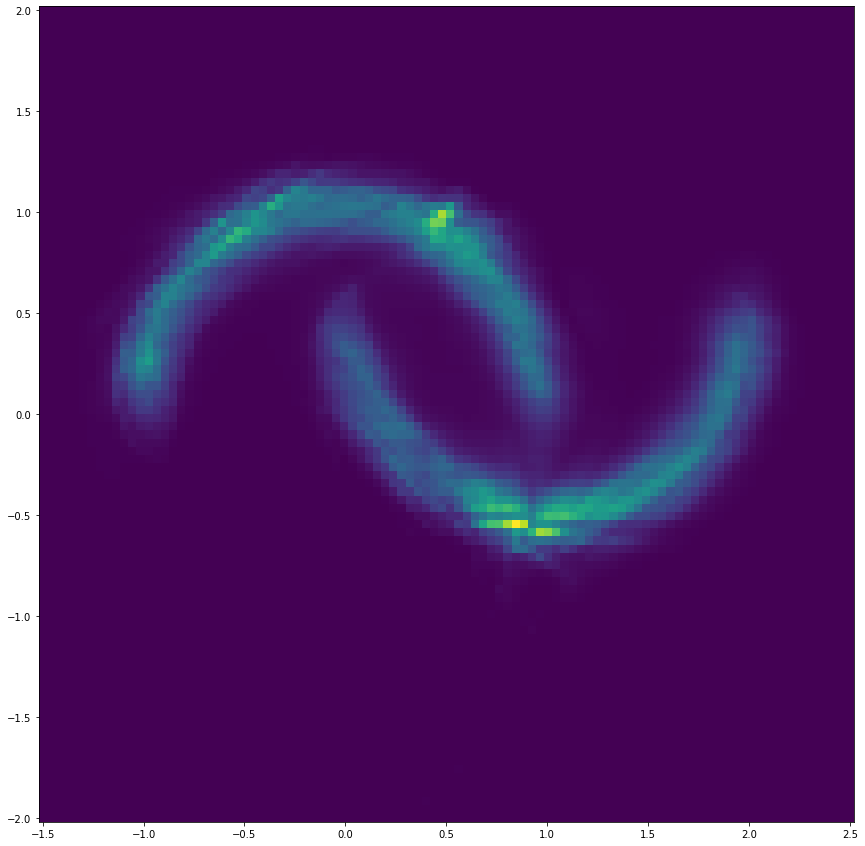

 20%|█████████▉                                        | 1999/10000 [06:09<24:13,  5.51it/s]

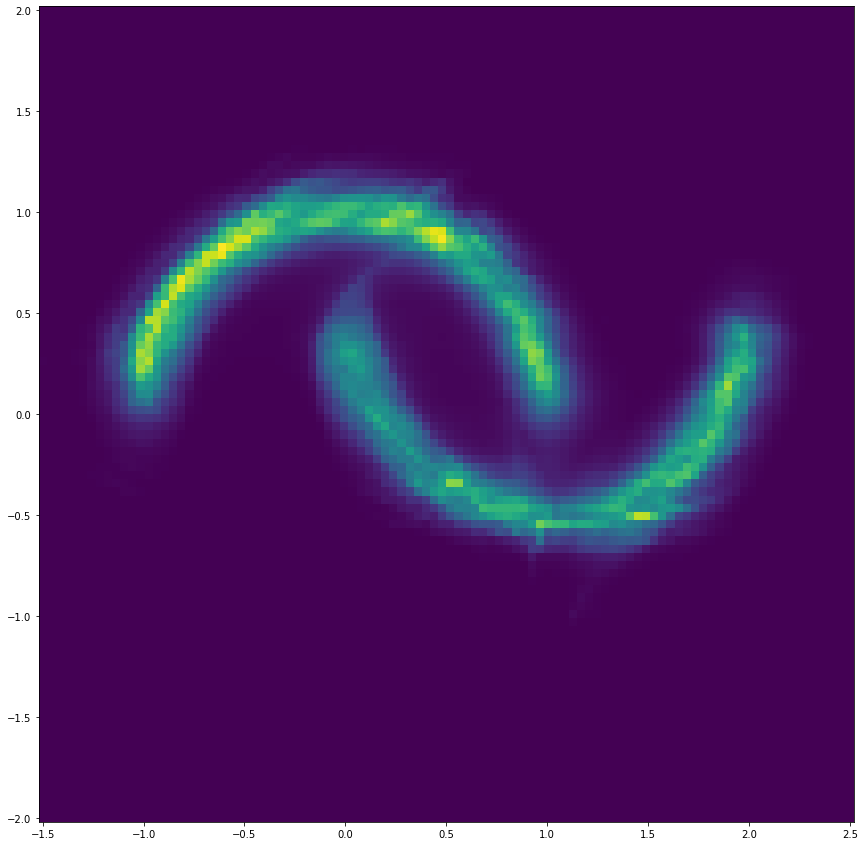

 25%|████████████▍                                     | 2499/10000 [07:40<22:53,  5.46it/s]

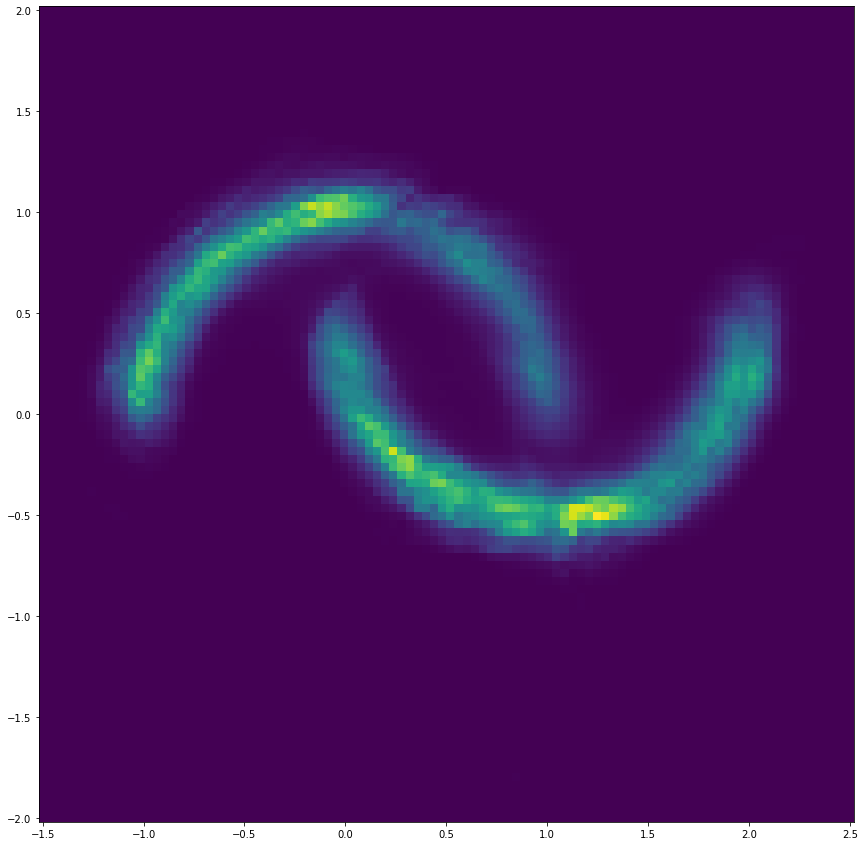

 27%|█████████████▌                                    | 2711/10000 [08:20<22:05,  5.50it/s]

In [ ]:
# Train model
max_iter = 10000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np, _ = make_moons(num_samples, noise=0.1)
    x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    loss = nfm.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Make layers Lipschitz continuous
    nf.utils.update_lipschitz(nfm, 5)
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Plot learned posterior distribution
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()